In [1]:
import numpy as np
import os
import pandas as pd
from jinja2 import Template
import subprocess
from matplotlib import pyplot as plt
#from multiprocessing import Pool
import multiprocessing
import sqlite3
import glob

In [2]:
from functools import partial

In [3]:
np.set_printoptions(precision=8, suppress=True)

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [5]:
# %load pso.py
from functools import partial
import numpy as np
from diversipy import hycusampling

def _obj_wrapper(func, args, kwargs, x):
    return func(x, *args, **kwargs)

def _is_feasible_wrapper(func, x):
    return np.all(func(x)>=0)

def _cons_none_wrapper(x):
    return np.array([0])

def _cons_ieqcons_wrapper(ieqcons, args, kwargs, x):
    return np.array([y(x, *args, **kwargs) for y in ieqcons])

def _cons_f_ieqcons_wrapper(f_ieqcons, args, kwargs, x):
    return np.array(f_ieqcons(x, *args, **kwargs))
    
def pso(func, lb, ub, ieqcons=[], f_ieqcons=None, args=(), kwargs={}, 
        swarmsize=100, omega=0.5, phip=0.5, phig=0.5, maxiter=100, 
        minstep=1e-8, minfunc=1e-8, debug=False, processes=1,
        particle_output=False):
    """
    Perform a particle swarm optimization (PSO)
   
    Parameters
    ==========
    func : function
        The function to be minimized
    lb : array
        The lower bounds of the design variable(s)
    ub : array
        The upper bounds of the design variable(s)
   
    Optional
    ========
    ieqcons : list
        A list of functions of length n such that ieqcons[j](x,*args) >= 0.0 in 
        a successfully optimized problem (Default: [])
    f_ieqcons : function
        Returns a 1-D array in which each element must be greater or equal 
        to 0.0 in a successfully optimized problem. If f_ieqcons is specified, 
        ieqcons is ignored (Default: None)
    args : tuple
        Additional arguments passed to objective and constraint functions
        (Default: empty tuple)
    kwargs : dict
        Additional keyword arguments passed to objective and constraint 
        functions (Default: empty dict)
    swarmsize : int
        The number of particles in the swarm (Default: 100)
    omega : scalar
        Particle velocity scaling factor (Default: 0.5)
    phip : scalar
        Scaling factor to search away from the particle's best known position
        (Default: 0.5)
    phig : scalar
        Scaling factor to search away from the swarm's best known position
        (Default: 0.5)
    maxiter : int
        The maximum number of iterations for the swarm to search (Default: 100)
    minstep : scalar
        The minimum stepsize of swarm's best position before the search
        terminates (Default: 1e-8)
    minfunc : scalar
        The minimum change of swarm's best objective value before the search
        terminates (Default: 1e-8)
    debug : boolean
        If True, progress statements will be displayed every iteration
        (Default: False)
    processes : int
        The number of processes to use to evaluate objective function and 
        constraints (default: 1)
    particle_output : boolean
        Whether to include the best per-particle position and the objective
        values at those.
   
    Returns
    =======
    g : array
        The swarm's best known position (optimal design)
    f : scalar
        The objective value at ``g``
    p : array
        The best known position per particle
    pf: arrray
        The objective values at each position in p
   
    """
   
    assert len(lb)==len(ub), 'Lower- and upper-bounds must be the same length'
    assert hasattr(func, '__call__'), 'Invalid function handle'
    lb = np.array(lb)
    ub = np.array(ub)
    assert np.all(ub>lb), 'All upper-bound values must be greater than lower-bound values'
   
    vhigh = np.abs(ub - lb)
    vlow = -vhigh

    # Initialize objective function
    obj = partial(_obj_wrapper, func, args, kwargs)
    
    # Check for constraint function(s) #########################################
    if f_ieqcons is None:
        if not len(ieqcons):
            if debug:
                print('No constraints given.')
            cons = _cons_none_wrapper
        else:
            if debug:
                print('Converting ieqcons to a single constraint function')
            cons = partial(_cons_ieqcons_wrapper, ieqcons, args, kwargs)
    else:
        if debug:
            print('Single constraint function given in f_ieqcons')
        cons = partial(_cons_f_ieqcons_wrapper, f_ieqcons, args, kwargs)
    is_feasible = partial(_is_feasible_wrapper, cons)

    # Initialize the multiprocessing module if necessary
    if processes > 1:
        import multiprocessing
        mp_pool = multiprocessing.Pool(processes)
        
    # Initialize the particle swarm ############################################
    S = swarmsize
    D = len(lb)  # the number of dimensions each particle has
    # x = np.random.rand(S, D)  # particle positions
    x = hycusampling.random_k_means(S, D)  # assigns points to voronoi centroids of the D-dimensional unit hypercube
    v = np.zeros_like(x)  # particle velocities
    p = np.zeros_like(x)  # best particle positions
    fx = np.zeros(S)  # current particle function values
    fs = np.zeros(S, dtype=bool)  # feasibility of each particle
    fp = np.ones(S)*np.inf  # best particle function values
    g = []  # best swarm position
    fg = np.inf  # best swarm position starting value
    
    # Initialize the particle's position
    x = lb + x*(ub - lb)

    # Calculate objective and constraints for each particle
    if processes > 1:
        fx = np.array(mp_pool.map(obj, x))
        fs = np.array(mp_pool.map(is_feasible, x))
    else:
        for i in range(S):
            fx[i] = obj(x[i, :])
            fs[i] = is_feasible(x[i, :])
       
    # Store particle's best position (if constraints are satisfied)
    i_update = np.logical_and((fx < fp), fs)
    p[i_update, :] = x[i_update, :].copy()
    fp[i_update] = fx[i_update]

    # Update swarm's best position
    i_min = np.argmin(fp)
    if fp[i_min] < fg:
        fg = fp[i_min]
        g = p[i_min, :].copy()
    else:
        # At the start, there may not be any feasible starting point, so just
        # give it a temporary "best" point since it's likely to change
        g = x[0, :].copy()
       
    # Initialize the particle's velocity
    v = vlow + np.random.rand(S, D)*(vhigh - vlow)
       
    # Iterate until termination criterion met ##################################
    it = 1
    while it <= maxiter:
        rp = np.random.uniform(size=(S, D))
        rg = np.random.uniform(size=(S, D))

        # Update the particles velocities
        v = omega*v + phip*rp*(p - x) + phig*rg*(g - x)
        # Update the particles' positions
        x = x + v
        # Correct for bound violations
        maskl = x < lb
        masku = x > ub
        x = x*(~np.logical_or(maskl, masku)) + lb*maskl + ub*masku

        # Update objectives and constraints
        if processes > 1:
            fx = np.array(mp_pool.map(obj, x))
            fs = np.array(mp_pool.map(is_feasible, x))
        else:
            for i in range(S):
                fx[i] = obj(x[i, :])
                fs[i] = is_feasible(x[i, :])

        # Store particle's best position (if constraints are satisfied)
        i_update = np.logical_and((fx < fp), fs)
        p[i_update, :] = x[i_update, :].copy()
        fp[i_update] = fx[i_update]

        # Compare swarm's best position with global best position
        i_min = np.argmin(fp)
        if fp[i_min] < fg:
            if debug:
                print('New best for swarm at iteration {:}: {:} {:}'\
                    .format(it, p[i_min, :], fp[i_min]))

            p_min = p[i_min, :].copy()
            stepsize = np.sqrt(np.sum((g - p_min)**2))

            if np.abs(fg - fp[i_min]) <= minfunc:
                print('Stopping search: Swarm best objective change less than {:}'\
                    .format(minfunc))
                if particle_output:
                    return p_min, fp[i_min], p, fp
                else:
                    return p_min, fp[i_min]
            elif stepsize <= minstep:
                print('Stopping search: Swarm best position change less than {:}'\
                    .format(minstep))
                if particle_output:
                    return p_min, fp[i_min], p, fp
                else:
                    return p_min, fp[i_min]
            else:
                g = p_min.copy()
                fg = fp[i_min]

        if debug:
            print('Best after iteration {:}: {:} {:}'.format(it, g, fg))
        it += 1

    print('Stopping search: maximum iterations reached --> {:}'.format(maxiter))
    
    if processes > 1:
        mp_pool.close()
    
    if not is_feasible(g):
        print("However, the optimization couldn't find a feasible design. Sorry")
    if particle_output:
        return g, fg, p, fp
    else:
        return g, fg


In [6]:
def make_param_dict(params, stand_id):
    ''' Single species
        FIXDG (diameter growth multiplier by species and diameter class)
        MORTMULT (background mortality rate multiplier by species and diameter class)
        SDIMAX (density-driven mortality parameter set for each species)
    '''
    param_dict = {}
    #stand input
    param_dict['stand_id'] = stand_id
    
    #growth factors
    #size classes: 3-5, 5-10, 10-15, 15-20, >20
    param_dict['FIXDGm_sp'] = round(params[0],8)
    param_dict['FIXDGm_0'] = round(params[1],8)
    param_dict['FIXDGm_1'] = round(params[2],8)
    param_dict['FIXDGm_2'] = round(params[3],8)
    param_dict['FIXDGm_3'] = round(params[4],8)
    param_dict['FIXDGm_4'] = round(params[5],8)
    #background mortality factors
    param_dict['MORTm_sp'] = round(params[0],8)
    param_dict['MORTm_0'] = round(params[6],8)
    param_dict['MORTm_1'] = round(params[7],8)
    param_dict['MORTm_2'] = round(params[8],8)
    param_dict['MORTm_3'] = round(params[9],8)
    param_dict['MORTm_4'] = round(params[10],8)

    #density driven mortality factors
    param_dict['SDI_MAX'] = int(params[11])
    param_dict['SDI_LB'] = 55
    param_dict['SDI_UB'] = 85
        
    return param_dict

def make_keyfile(template, param_dict):
    filename = './keyfiles/{}.key'.format(param_dict['stand_id'])
    keyfile_path = os.path.abspath(filename)
    with open(keyfile_path,'w') as keyfile:
        keyfile.write(template.render(**param_dict))

    return keyfile_path


def get_run_data(stand_id):
    CONN_STR = sqlite3.connect('./keyfiles/{}.db'.format(stand_id))
    run_data = pd.read_sql_query("SELECT * from fvs_summary", CONN_STR).set_index('standid')

    return run_data


def get_groundtruth(stand_id):
    STAND_DATA = './FIA_conds_DF.csv'
    df = pd.read_csv(STAND_DATA).set_index('stand_id')

    return df.loc[stand_id]

def get_residuals(stand_id):

    METRICS = ['acc','mort']
    pred = get_run_data(stand_id)[METRICS].first()
    obs = get_groundtruth(stand_id)[METRICS].first()

    residuals = pred - obs
    # sse = ((residuals)**2)
    # mae = residuals.abs()
    # bias = residuals
    
    return residuals

def get_keyfile_template(path_to_template):
    with open(path_to_template, 'r') as base_keyfile:
        template = Template(base_keyfile.read())
    return template


def run_fvs(params, stand_id):
    param_dict = make_param_dict(params, stand_id)
    KEYFILE_TEMPLATE = '/models/Base_Rx.key'
    template = get_keyfile_template(KEYFILE_TEMPLATE)
    keyfile = make_keyfile(template, param_dict)

    proc = subprocess.call(['/storage/src/open-fvs/trunk/bin/FVSpn',
                           '--keywordfile={}'.format(keyfile)],
                          stderr=subprocess.PIPE,
                          stdout=subprocess.PIPE)

    # cleanup output files
    os.remove('./keyfiles/{}.trl'.format(stand_id))
    os.remove('./keyfiles/{}.out'.format(stand_id))
    os.remove('./keyfiles/{}.key'.format(stand_id))

    return proc

# create fucntion to caluclate sse, mae, and bias
# def obj_fun(stand_list):
#     for x stand get residuals 
#     concat into single dataframe
#     calc sse, mae, bias for each variable

In [ ]:
def batch_fvs(stand_list, poolnum):
    # should be run within if __name__ == "__main__"

    # create a pool object
    p = multiprocessing.Pool(poolnum)
    # map stand list to fvs_run function
    proc = p.map(run_fvs, stand_list)

    return proc

In [ ]:
def opt_func(stand_list, LB, UB):

    x, f_x = pso(partial(batch_fvs, stand_list=stand_list),   
                 LB, UB, 
                 swarmsize=64,
                 maxiter=25,
                 processes=32,
                 minfunc=0)

In [7]:
local_lb = [0.01,  # REGDMULT
      0.01,  # BAIm_0
      0.01,  # BAIm_1
      0.01,  # BAIm_2
      0.01,  # BAIm_3
      0.01,  # MORTm_0
      0.01,  # MORTm_1
      0.01,  # MORTm_2
      0.01]  # MORTm_3

local_ub = [3.50,  # REGDMULT
      10.00,  # BAIm_0
      5.00,  # BAIm_1
      3.00,  # BAIm_2
      5.00,  # BAIm_3
      0.50,  # MORTm_0
      5.00,  # MORTm_1
      10.00,  # MORTm_2
      5.00]  # MORTm_3

In [9]:
LB = [300,   # sdi_max
      0.50]  # DF_DBH large tree adjustment
             
UB = [500,   # sdi_max
      1.10]  # DF_DBH large tree adjustment
SITES = [145, 135, 125, 115, 105, 95, 85, 75, 65]
pso_results = pd.DataFrame(index=SITES, columns=['sdi_max', 'df_dbh', 'f_x'])
xs = []
fxs = []
for site in SITES:
    empty_database()
    x, f_x = pso(partial(run_fvs, site_index=site, run_type='global'),
                 LB, UB,  # bounds
                 swarmsize=64,
                 maxiter=25,
#                  debug=True,
                 processes=32,
                 minfunc=0) # don't stop early
    xs.append(x)
    fxs.append(f_x)
    pso_results.loc[site, 'sdi_max'] = np.round(x[0],0).astype(int)
    pso_results.loc[site, 'df_dbh'] = np.round(x[1],8)
    pso_results.loc[site, 'f_x'] = f_x
print(pso_results)    

Stopping search: maximum iterations reached --> 25
Stopping search: maximum iterations reached --> 25
Stopping search: maximum iterations reached --> 25
Stopping search: maximum iterations reached --> 25
Stopping search: maximum iterations reached --> 25
Stopping search: maximum iterations reached --> 25
Stopping search: maximum iterations reached --> 25
Stopping search: maximum iterations reached --> 25
Stopping search: maximum iterations reached --> 25
    sdi_max    df_dbh      f_x
145     446   0.95872  1.36933
135     402   1.07936  1.63002
125     399  0.973043  1.91889
115     400  0.893233  1.91118
105     414  0.788779  1.82107
95      425  0.688981  1.64722
85      404  0.671923  1.60773
75      473  0.552016   1.5992
65      404  0.524992  1.77058


In [13]:
xs

[array([446.217267  ,   0.95872039]),
 array([402.24513417,   1.07936384]),
 array([399.35922062,   0.97304307]),
 array([399.86436598,   0.89323341]),
 array([414.29677886,   0.78877946]),
 array([424.65297791,   0.6889809 ]),
 array([403.59207937,   0.67192323]),
 array([473.01700029,   0.55201569]),
 array([404.05791047,   0.52499206])]

In [17]:
pso_results[['sdi_max', 'df_dbh']].to_csv('DF_sdimax_and_dbh_adjustments_by_siteindex.csv', index_label = 'SI')

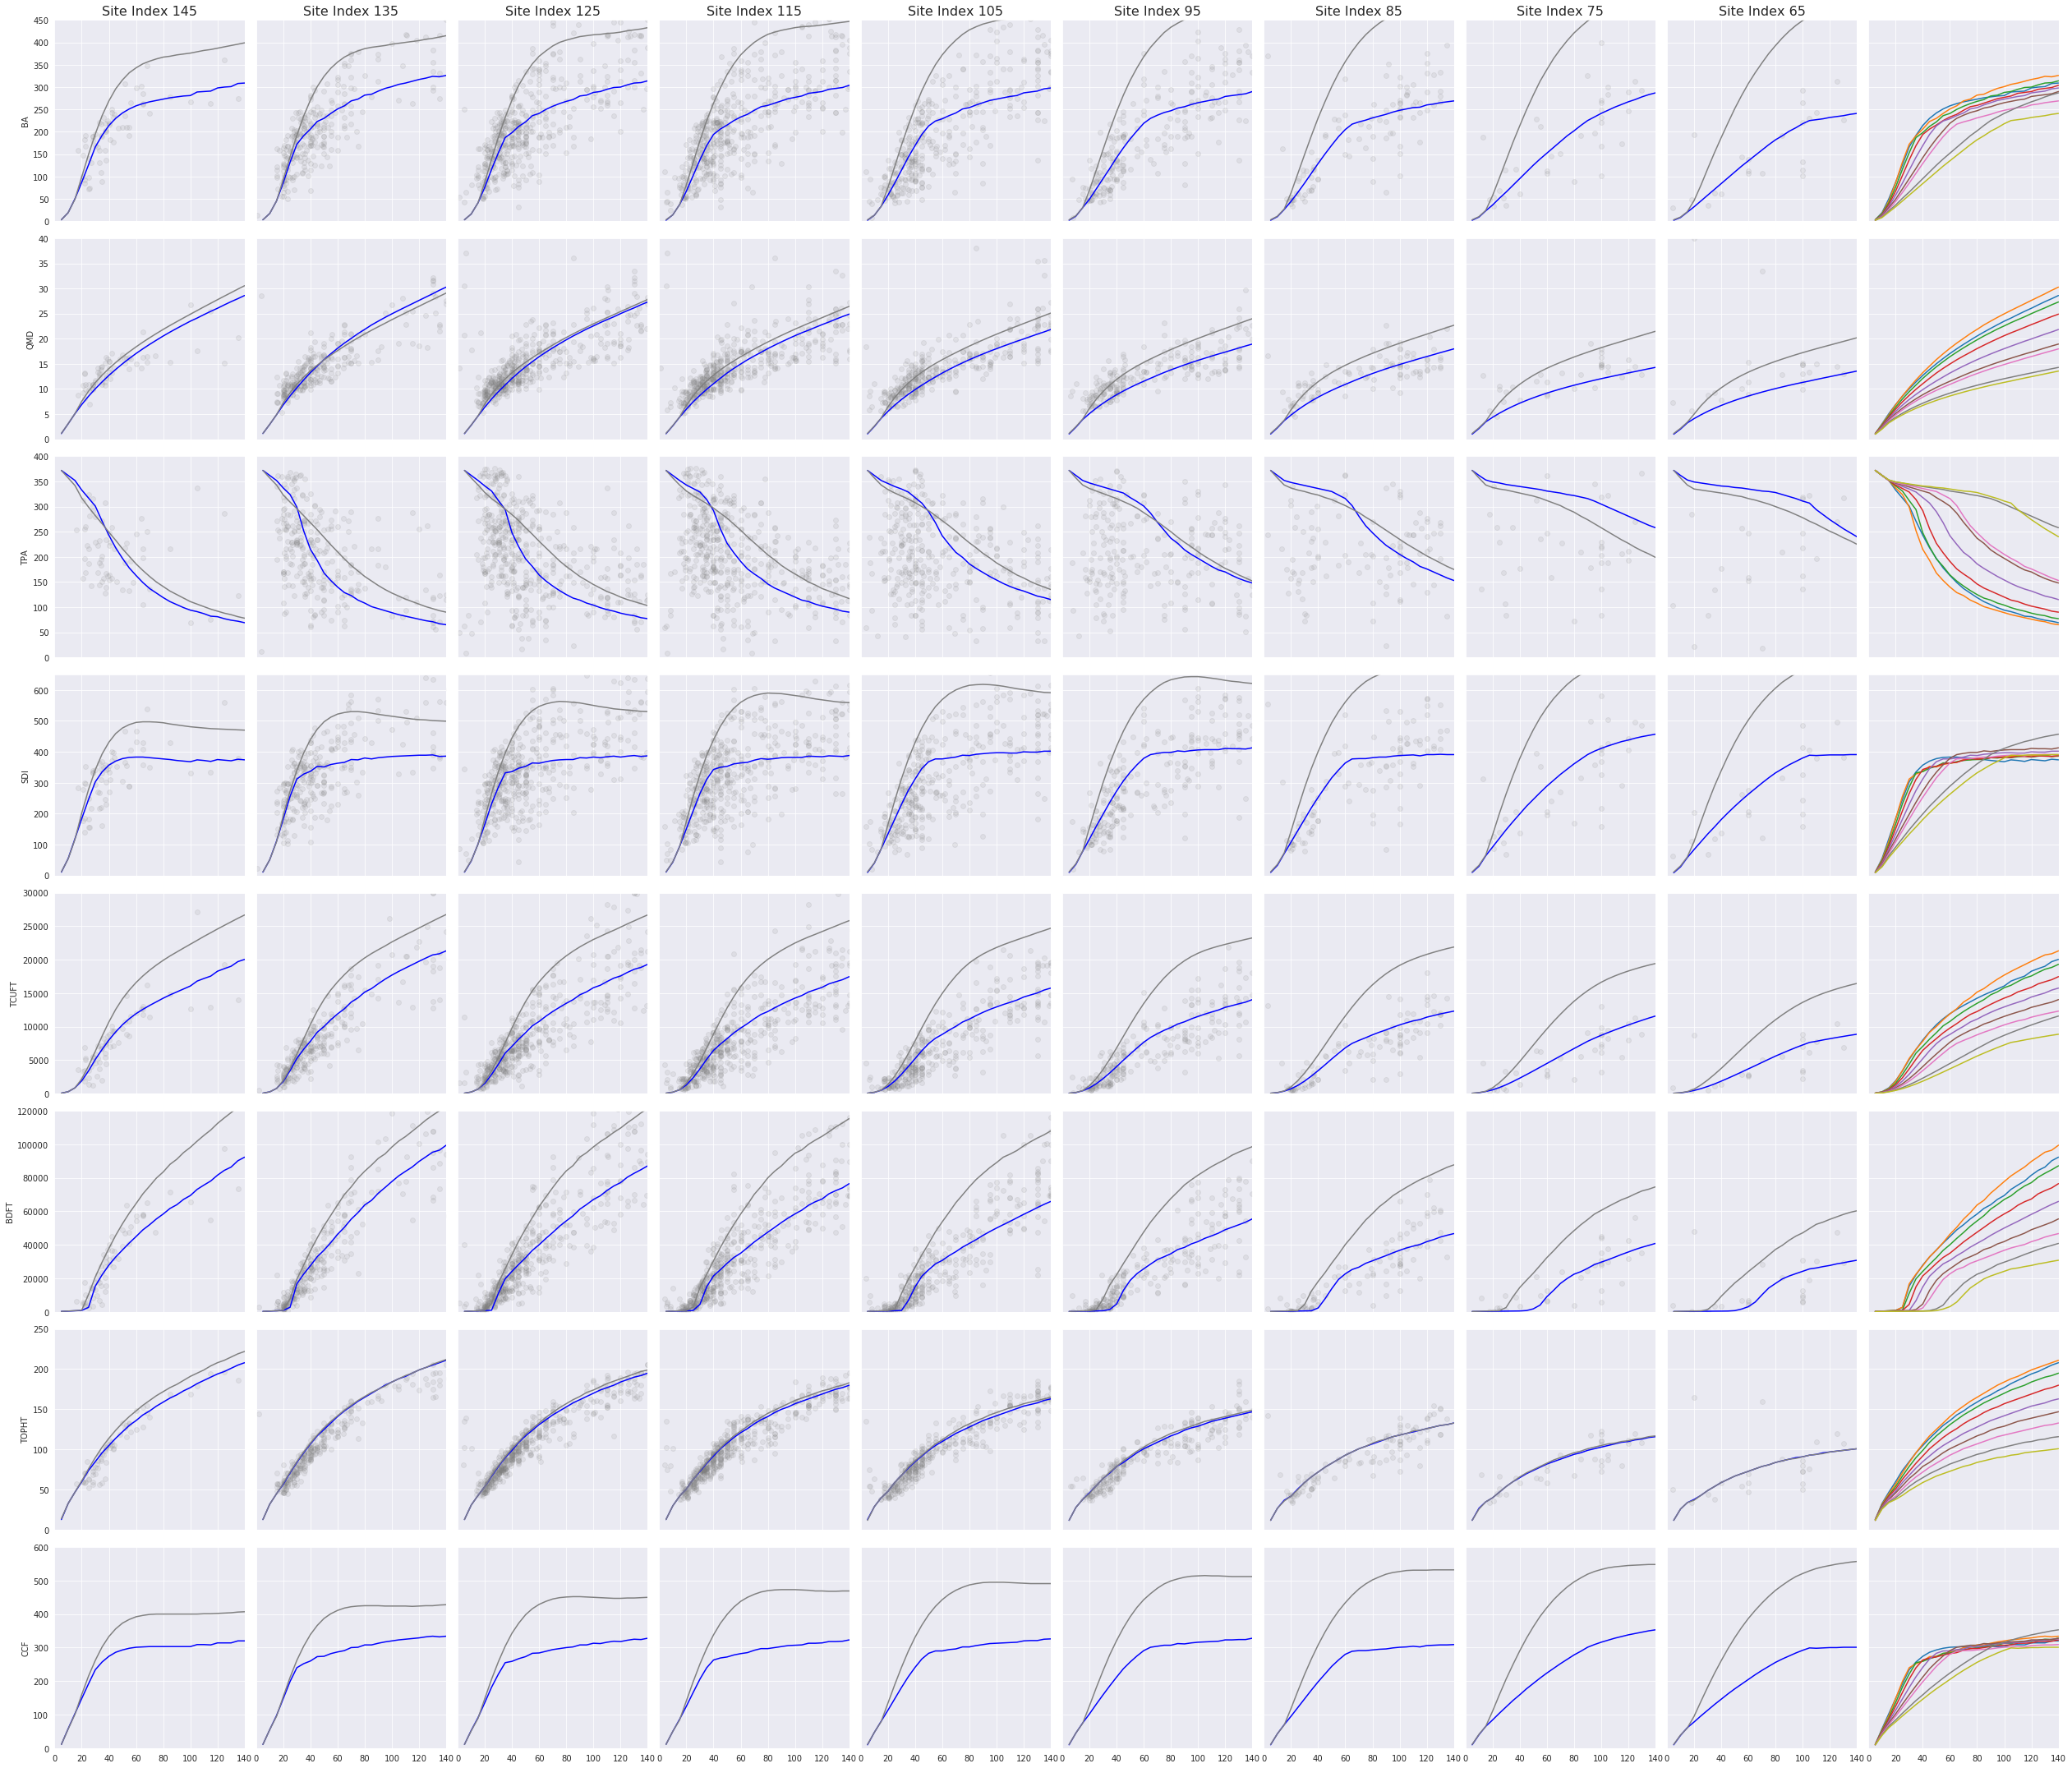

In [10]:
METRICS = ['ba', 'qmd', 'tpa', 'sdi', 'tcuft', 'bdft', 'topht', 'ccf']
YMAXES = {'ba':450, 'qmd': 40, 'tpa':400, 'sdi':650, 'tcuft':30000, 'bdft':120000, 'topht':250, 'ccf': 600}
SITES = [145, 135, 125, 115, 105, 95, 85, 75, 65]

fig, axs = plt.subplots(len(METRICS), len(SITES)+1, figsize=(35,30), sharex=True, sharey='row')
for j, site in enumerate(SITES):
    default_fvs = run_fvs(params=['',1.0], 
                          site_index=site, 
                          run_type='global', 
                          get_data=True, 
                          get_metrics=METRICS).sort_values(by='age')
    this_run = run_fvs(params=pso_results.loc[site][['sdi_max', 'df_dbh']],  
                       site_index=site, 
                       run_type='global', 
                       get_data=True, 
                       get_metrics=METRICS).sort_values(by='age')
    
    axs[0, j].set_title('Site Index {}'.format(site), fontsize=16)
    
    for i, metric in enumerate(METRICS):
        try:  # fia data doesn't always include the metrics we want
            fia_data = get_bounded_FIA(site, [metric], 0.025, 0.975)
            axs[i, j].scatter(fia_data.index, fia_data[metric], color='gray', alpha=0.12)
        except:
            pass

        axs[i, j].plot(this_run.age, this_run[metric], label='best-fit', color='blue')
        axs[i, -1].plot(this_run.age, this_run[metric], label=site)
        axs[i, j].plot(default_fvs.age, default_fvs[metric], label='default', color='gray')
        axs[i, 0].set_ylabel(metric.upper())
        axs[i, 0].set_ylim(0, YMAXES[metric])


axs[0, 0].set_xlim(0,140)
plt.tight_layout()